In [1]:
import numpy as np
import numba
import scipy.sparse as ssp
import scipy.stats
import time
import sys
import pdb
%load_ext line_profiler
%load_ext autoreload
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)

## nu = 1/3

In [2]:
Nphi = lambda Ne, p, q: q*Ne/p

In [3]:
p = 1; q = 3
print("N_e | N_H       | N_H (sector) | N_elem     | N_H (Haldane) | N_H (Yoshioka)")
for Ne in np.arange(3, 16):
    NH1 = scipy.special.comb(Nphi(Ne, p, q), Ne)
    print("{0:2d}  | {1:.3e} | {2:.3e}    | {5:.4e} | {3:.4e}    | {4:.4e}".format(
#             Ne, NH1, NH1/(3*Ne), NH1/(3*Ne*Ne)))
           Ne, NH1, NH1/(Nphi(Ne, p, q)), NH1/(q*Ne*Ne), NH1/(Nphi(Ne, p, q)/q)**2, 
           NH1*(Nphi(Ne, p, q)-Ne)*Ne*(Ne-1)/(4*Nphi(Ne, p, q))))

N_e | N_H       | N_H (sector) | N_elem     | N_H (Haldane) | N_H (Yoshioka)
 3  | 8.400e+01 | 9.333e+00    | 8.4000e+01 | 3.1111e+00    | 9.3333e+00
 4  | 4.950e+02 | 4.125e+01    | 9.9000e+02 | 1.0312e+01    | 3.0938e+01
 5  | 3.003e+03 | 2.002e+02    | 1.0010e+04 | 4.0040e+01    | 1.2012e+02
 6  | 1.856e+04 | 1.031e+03    | 9.2820e+04 | 1.7189e+02    | 5.1567e+02
 7  | 1.163e+05 | 5.537e+03    | 8.1396e+05 | 7.9102e+02    | 2.3731e+03
 8  | 7.355e+05 | 3.064e+04    | 6.8644e+06 | 3.8306e+03    | 1.1492e+04
 9  | 4.687e+06 | 1.736e+05    | 5.6242e+07 | 1.9287e+04    | 5.7862e+04
10  | 3.005e+07 | 1.002e+06    | 4.5068e+08 | 1.0015e+05    | 3.0045e+05
11  | 1.935e+08 | 5.865e+06    | 3.5482e+09 | 5.3316e+05    | 1.5995e+06
12  | 1.252e+09 | 3.477e+07    | 2.7537e+10 | 2.8974e+06    | 8.6922e+06
13  | 8.122e+09 | 2.083e+08    | 2.1118e+11 | 1.6021e+07    | 4.8062e+07
14  | 5.286e+10 | 1.259e+09    | 1.6034e+12 | 8.9898e+07    | 2.6970e+08
15  | 3.449e+11 | 7.664e+09    | 1.2070e+13 | 5

## nu = 1/5

In [4]:
print("N_e | N_H       | N_H (sector) | N_H (Haldane)")
for N in np.arange(3, 12):
    NH1 = scipy.special.comb(5*N, N)
    print("{0:2d}  | {1:.3e} | {2:.3e}    | {3:.4e}".format(N, NH1, NH1/(3*N), NH1/(3*N*N)))

N_e | N_H       | N_H (sector) | N_H (Haldane)
 3  | 4.550e+02 | 5.056e+01    | 1.6852e+01
 4  | 4.845e+03 | 4.038e+02    | 1.0094e+02
 5  | 5.313e+04 | 3.542e+03    | 7.0840e+02
 6  | 5.938e+05 | 3.299e+04    | 5.4979e+03
 7  | 6.725e+06 | 3.202e+05    | 4.5745e+04
 8  | 7.690e+07 | 3.204e+06    | 4.0055e+05
 9  | 8.862e+08 | 3.282e+07    | 3.6468e+06
10  | 1.027e+10 | 3.424e+08    | 3.4241e+07
11  | 1.197e+11 | 3.626e+09    | 3.2962e+08


In [5]:
print("N_e | N_H       | N_H (sector) | N_H (Haldane)")
for N in np.arange(4, 18, 2):
    NH1 = scipy.special.comb(5*N//2, N)
    print("{0:2d}  | {1:.3e} | {2:.3e}    | {3:.4e}".format(N, NH1, NH1/(3*N), NH1/(3*N*N)))

N_e | N_H       | N_H (sector) | N_H (Haldane)
 4  | 2.100e+02 | 1.750e+01    | 4.3750e+00
 6  | 5.005e+03 | 2.781e+02    | 4.6343e+01
 8  | 1.260e+05 | 5.249e+03    | 6.5609e+02
10  | 3.269e+06 | 1.090e+05    | 1.0896e+04
12  | 8.649e+07 | 2.403e+06    | 2.0022e+05
14  | 2.320e+09 | 5.524e+07    | 3.9455e+06
16  | 6.285e+10 | 1.309e+09    | 8.1839e+07


## NUMBA EXPERIMENTS

In [6]:
import landau
import utils
import hilbert
import hilbertnoNumba

In [7]:
Nphi = 21
Ne = 7

torus1 = landau.Torus(Nphi, aspect_ratio=1.0)
vParams = {'n': 1, 'x': np.inf} # Coulomb power law, Gaussian cut-off
hamParams= {'alpha': 1.0, 'n': 0, 'Nphi': Nphi} # mass anisotropy, Landau level index

In [8]:
# %%timeit
pot1 = landau.Potential()
pot1.setV2(torus1, vParams, hamParams)
T4 = np.real(utils.Utils.make4tensorsym(torus1, pot1))

hilb = [None]*Ne
hilbLen = [None]*Ne
dictx = [None]*Ne

for sector in range(Ne):
    hilb[sector], hilbLen[sector] = utils.Utils.getHilb(Nphi, Ne, sector)
    dictx[sector] = hilbert.getDict(hilb[sector])

In [9]:
## test if matvec is the same as mat
E_all = [None]*Ne
V_all = [None]*Ne

for sector in range(Ne):
    NH = len(hilb[sector])
    dij = hilbert.getMat(Nphi, Ne, NH, hilb[sector], hilbLen[sector], T4, dictx[sector])
    HMat = ssp.coo_matrix((dij[0, :], 
                          (dij[1, :], dij[2, :])),
                          shape=(sum(hilbLen[sector]), sum(hilbLen[sector])))
    HMat = HMat.tocsr()
    E_all[sector], V_all[sector] = scipy.sparse.linalg.eigsh(HMat, k=6, which='SA')
# Out1 = HMat.dot(npOnes)
# Out2 = hilbert0.getMatVec(npOnes)

In [10]:
E_all

[array([-1.69095466, -1.62157766, -1.62157766, -1.61067501, -1.61067501,
        -1.57890671]),
 array([-1.62021325, -1.62021325, -1.61655003, -1.61655003, -1.58765936,
        -1.58765936]),
 array([-1.62860296, -1.62860296, -1.62021325, -1.62021325, -1.61067501,
        -1.60704811]),
 array([-1.62157766, -1.61655003, -1.61655003, -1.61129611, -1.61129611,
        -1.60704811]),
 array([-1.62157766, -1.61655003, -1.61655003, -1.61129611, -1.61129611,
        -1.60704811]),
 array([-1.62860296, -1.62860296, -1.62021325, -1.62021325, -1.61067501,
        -1.60704811]),
 array([-1.62021325, -1.62021325, -1.61655003, -1.61655003, -1.58765936,
        -1.58765936])]

In [11]:
E_all[2][0] - E_all[0][0]

0.06235170121672717

## SPEED TESTS

In [19]:
Nphi = 27
Ne = 9
sector = 0

torus1 = landau.Torus(Nphi, aspect_ratio=1.0)
vParams = {'n': 1, 'x': np.inf} # Coulomb power law, Gaussian cut-off
hamParams= {'alpha': 1.0, 'n': 0, 'Nphi': Nphi} # mass anisotropy, Landau level index

pot1 = landau.Potential()
pot1.setV2(torus1, vParams, hamParams)
T4 = np.real(utils.Utils.make4tensorsym(torus1, pot1))

hilb_s, hilbLen_s = utils.Utils.getHilb(Nphi, Ne, sector)
dictx = hilbert.getDict(hilb_s)
NH = len(hilb_s)
dij = hilbert.getMat(Nphi, Ne, NH, hilb_s, hilbLen_s, T4, dictx)
HMat = ssp.coo_matrix((dij[0, :], 
                      (dij[1, :], dij[2, :])),
                      shape=(sum(hilbLen_s), sum(hilbLen_s)))
HMat = HMat.tocsr()

from functools import partial
newMatVec = partial(hilbert.getMatVec, Nphi=Nphi, Ne=Ne, NH=len(hilb_s), hilb=hilb_s, 
                    hilbLen=hilbLen_s, T4=T4, dictx=dictx)

npOnes = np.ones(sum(hilbLen_s))

In [20]:
t1 = time.time()
v1 = HMat.dot(npOnes)
t2 = time.time()
v2 = newMatVec(npOnes)
t3 = time.time()
print(t3 - t2)
print(t2 - t1)

4.023050785064697
0.06173110008239746


In [18]:
np.max(np.abs(v1-v2))

5.10702591327572e-15

(0, 2.5)

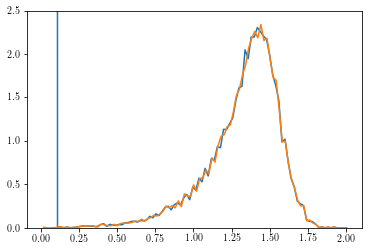

In [38]:
h, b = np.histogram((np.abs(HMat.data)), bins=100)
h2, b2 = np.histogram(np.abs(HMat.diagonal()), bins = 100)
f, ax = plt.subplots()
ax.plot(0.5*(b[1:]+b[:-1]), h/(np.sum(h)*(b[1]-b[0])) / HMat.shape[0] * HMat.size)
ax.plot(0.5*(b2[1:]+b2[:-1]), h2/(np.sum(h2)*(b2[1]-b2[0])))
ax.set_ylim(0, 2.5)

In [204]:
peep = np.sort(np.log10(np.abs(HMat.data)))[::-1]

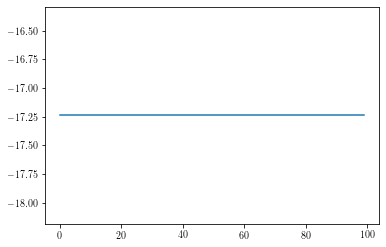

In [205]:
f, ax = plt.subplots()
ax.plot(peep[38_242_400:38_242_500])

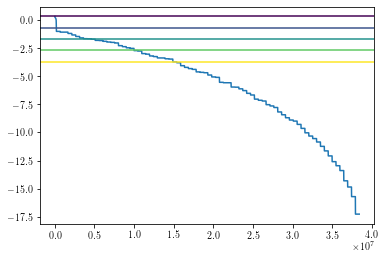

In [207]:
f, ax = plt.subplots()
ax.plot(100*np.arange(len(peep[::100])), peep[::100])
for m in range(5):
    ax.axhline(peep[0]-m, color = plt.cm.viridis(m/4))

In [9]:
run runSim.py 32 0 7 /tigress/ak20/QH/anisoMayCoulomb/

In [12]:
poop = np.load('/tigress/ak20/QH/anisoMayCoulomb/LL0/ar025/Nphi21_Ne7_sector3_alpha10_E.npy')

In [13]:
poop

array([-1.62157766, -1.61655003, -1.61655003, -1.61129611, -1.61129611,
       -1.60704811])

In [ ]:
array([-1.62157766, -1.61655003, -1.61655003, -1.61129611, -1.61129611,
        -1.60704811])

In [4]:
alp_arr = np.r_[1.0:4.01:0.1] # 31
asp_arr = np.array([0.8, 1, 1.25]) # 3
Ne_arr = np.array([6, 7, 8])

E0 = np.zeros((len(Ne_arr), len(asp_arr), len(alp_arr))) * np.nan
cf = 0
fol = '/tigress/ak20/QH/aniso1/'

for cNe, Ne in enumerate(Ne_arr):
    Nphi = 3*Ne
    for casp, aspect_ratio in enumerate(asp_arr):
        for calp, alpha in enumerate(alp_arr):
            
            E_all = np.zeros(0)
            
            sectorMax = False
            for sector in range(Ne):
                fil = 'Nphi{0:d}_Ne{1:d}_sector{2:d}_alpha{3:d}_ar{4:d}'.format(
                       Nphi, Ne, sector, int(round(10*alpha)), int(round(100*aspect_ratio)))
                try:
                    dat = np.load(fol+fil+'_E.npy')
                    cf += 1
                    E_all = np.r_[E_all, dat]
                    if sector == Ne - 1:
                        sectorMax = True
                except FileNotFoundError:
                    pass
            
            if sectorMax:
                E_all.sort()
                E0[cNe, casp, calp] = E_all[1] - E_all[0]

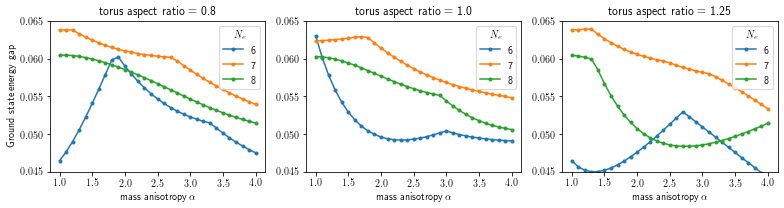

In [5]:
f, (ax, bx, cx) = plt.subplots(1, 3, figsize=(11, 3))
ylims = [0.045, 0.065]

ax.plot(alp_arr, E0[0, 0, :], label="6", marker='.')
ax.plot(alp_arr, E0[1, 0, :], label="7", marker='.')
ax.plot(alp_arr, E0[2, 0, :], label="8", marker='.')
ax.set_xlabel(r'mass anisotropy $\alpha$')
ax.set_ylabel(r'Ground state energy gap')
ax.set_ylim(ylims)
ax.legend(loc='best', title=r'$N_e$')
ax.set_title(r'torus aspect ratio = 0.8')

bx.plot(alp_arr, E0[0, 1, :], label="6", marker='.')
bx.plot(alp_arr, E0[1, 1, :], label="7", marker='.')
bx.plot(alp_arr, E0[2, 1, :], label="8", marker='.')
bx.set_xlabel(r'mass anisotropy $\alpha$')
bx.set_ylim(ylims)
bx.legend(loc='best', title=r'$N_e$')
bx.set_title(r'torus aspect ratio = 1.0')

cx.plot(alp_arr, E0[0, 2, :], label="6", marker='.')
cx.plot(alp_arr, E0[1, 2, :], label="7", marker='.')
cx.plot(alp_arr, E0[2, 2, :], label="8", marker='.')
cx.set_xlabel(r'mass anisotropy $\alpha$')
cx.set_ylim(ylims)
cx.legend(loc='best', title=r'$N_e$')
cx.set_title(r'torus aspect ratio = 1.25')

f.tight_layout()
f.savefig('/home/ak20/QH/plots/aniso1.pdf', bbox_inches='tight', transparent=True)

In [333]:
E0 = np.zeros((len(Ne_arr), len(asp_arr), len(alp_arr), 8, 6)) * np.nan
for cNe, Ne in enumerate(Ne_arr[:]):
    Nphi = 3*Ne
    for casp, aspect_ratio in enumerate(asp_arr):
        for calp, alpha in enumerate(alp_arr):
            
            E_all = np.zeros(0)
            
            for sector in range(Ne):
                fil = 'Nphi{0:d}_Ne{1:d}_sector{2:d}_alpha{3:d}_ar{4:d}'.format(
                       Nphi, Ne, sector, int(round(10*alpha)), int(round(100*aspect_ratio)))
                try:
                    E0[cNe, casp, calp, sector, :] = np.load(fol+fil+'_E.npy')
                    cf += 1
#                     E_all = np.r_[E_all, dat]
                except FileNotFoundError:
                    pass
                
#             E_all.sort()
#             E0[cNe, casp, calp] = E_all[1] - E_all[0]

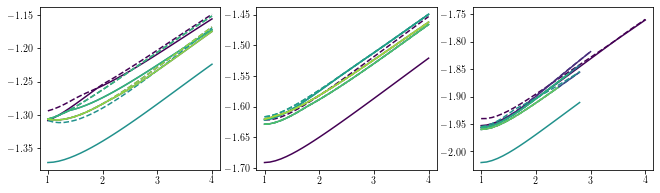

In [334]:
f, (ax, bx, cx) = plt.subplots(1, 3, figsize=(11, 3))

for sector in np.arange(7):
    ax.plot(alp_arr, E0[0, 1, :, sector, 0], color=plt.cm.viridis(sector/6))
    ax.plot(alp_arr, E0[0, 1, :, sector, 1], color=plt.cm.viridis(sector/6), ls='--')
    
    bx.plot(alp_arr, E0[1, 1, :, sector, 0], color=plt.cm.viridis(sector/7))
    bx.plot(alp_arr, E0[1, 1, :, sector, 1], color=plt.cm.viridis(sector/7), ls='--')
    
    cx.plot(alp_arr, E0[2, 1, :, sector, 0], color=plt.cm.viridis(sector/8))
    cx.plot(alp_arr, E0[2, 1, :, sector, 1], color=plt.cm.viridis(sector/8), ls='--')